# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

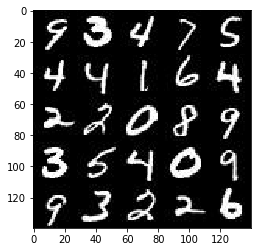

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

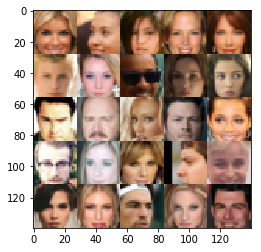

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real input images tensor
    input_imgs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_imgs')
    # z input
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    # Learning rate
    learning_rate = tf.placeholder(tf.float32, [], name='leaning_rate')

    return (input_imgs, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Image shape -> 28x28x3
        d1 = tf.layers.conv2d(images, filters=64, kernel_size=3, strides=2, padding='same')
        lrelu1 = tf.maximum(alpha * d1, d1)
        # 14x14x64
        
        d2 = tf.layers.conv2d(lrelu1, filters=128, kernel_size=3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(d2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        d3 = tf.layers.conv2d(lrelu2, filters=256, kernel_size=3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(d3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(lrelu3, [-1, 4 * 4 *256])
        logits = tf.layers.dense(flat, units=1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        g1 = tf.layers.dense(z, units=4 * 4 * 256)
        g1 = tf.reshape(g1, [-1, 4, 4, 256])
        bn1 = tf.layers.batch_normalization(g1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x256
        
        g2 = tf.layers.conv2d_transpose(lrelu1, filters=128, kernel_size=4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(g2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        g3 = tf.layers.conv2d_transpose(lrelu2, filters=64, kernel_size=3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(g3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(lrelu3, filters=out_channel_dim, kernel_size=3, strides=2, 
                                            padding='same')
        # 28x28xout_channel_dim
        
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator model
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator model with real inputs
    d_model_real, d_logits_real = discriminator(input_real)
    
    # Discriminator model with fake inputs
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Generator loss
    g_labels = tf.ones_like(d_model_fake)
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    # Discriminator loss (real images)
    d_labels_real = tf.ones_like(d_model_real)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    
    # Discriminator loss (fake images)
    d_labels_fake = tf.zeros_like(d_model_fake)
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    
    # Discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # List of all weights and bias
    t_vars = tf.trainable_variables()
    
    # List of weights and bias in discriminator model
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # List of weights and bias in generator model
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_training_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_training_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_training_op, g_training_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode, dataset_name):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    :param dataset_name: String indicating the dataset
    """
    # Reset graph
    tf.reset_default_graph
    
    # Build model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Auxiliar
    saver = tf.train.Saver()
    losses= []
    steps = 0
    
    # Start session
    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        
        # Train
        for epoch_i in range(epoch_count):
            for batch in get_batches(batch_size):
                #time.sleep(0.05)
                steps += 1
                
                # Rescale images
                batch = batch * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch, input_z: batch_z, lr: learning_rate})
                
                # Print losses and save them to view after training
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({input_real: batch, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {:02d} | ".format(epoch_i + 1),
                          "Step {:4d} | ".format(steps),
                          "d_loss = {:.8f} | ".format(train_loss_d), 
                          "g_loss = {:.8f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                
                # Show generator outputs
                if steps % 100 == 0:
                    n_channels = 1 if data_image_mode == 'L' else 3
                    show_generator_output(sess, 36, input_z, n_channels, data_image_mode)
        
        # Save trained model
        saver.save(sess, './checkpoints/ ' + dataset_name + '_generator.ckpt')
    
    # Display losses
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 01 |  Step   25 |  d_loss = 0.11449915 |  g_loss = 2.62365746
Epoch 01 |  Step   50 |  d_loss = 0.00119197 |  g_loss = 8.21685219
Epoch 01 |  Step   75 |  d_loss = 0.12149295 |  g_loss = 3.37814569
Epoch 01 |  Step  100 |  d_loss = 0.88789684 |  g_loss = 5.70016003


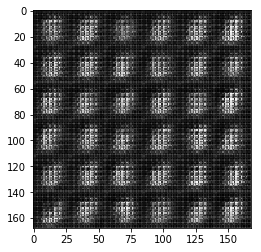

Epoch 01 |  Step  125 |  d_loss = 0.20031929 |  g_loss = 2.70123935
Epoch 01 |  Step  150 |  d_loss = 0.99322730 |  g_loss = 1.33867407
Epoch 01 |  Step  175 |  d_loss = 1.10059905 |  g_loss = 5.07874966
Epoch 01 |  Step  200 |  d_loss = 0.75554007 |  g_loss = 2.26717758


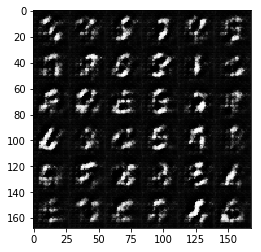

Epoch 01 |  Step  225 |  d_loss = 1.50986719 |  g_loss = 0.90051579
Epoch 01 |  Step  250 |  d_loss = 0.98051286 |  g_loss = 1.94879246
Epoch 01 |  Step  275 |  d_loss = 0.63843137 |  g_loss = 1.90377164
Epoch 01 |  Step  300 |  d_loss = 1.07590592 |  g_loss = 0.73707098


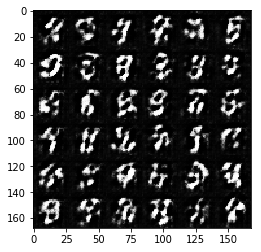

Epoch 01 |  Step  325 |  d_loss = 1.14556468 |  g_loss = 0.53617382
Epoch 01 |  Step  350 |  d_loss = 0.91289449 |  g_loss = 0.72612721
Epoch 01 |  Step  375 |  d_loss = 0.67112941 |  g_loss = 1.02140260
Epoch 01 |  Step  400 |  d_loss = 0.79347879 |  g_loss = 0.86935127


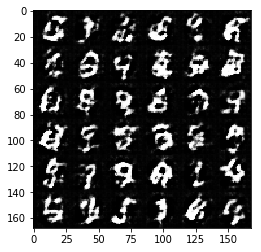

Epoch 01 |  Step  425 |  d_loss = 1.37658119 |  g_loss = 0.39138210
Epoch 01 |  Step  450 |  d_loss = 0.61526591 |  g_loss = 1.61728311
Epoch 01 |  Step  475 |  d_loss = 1.03436685 |  g_loss = 0.59059894
Epoch 01 |  Step  500 |  d_loss = 0.83798927 |  g_loss = 0.88586372


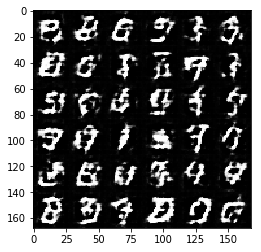

Epoch 01 |  Step  525 |  d_loss = 0.79403055 |  g_loss = 0.93248606
Epoch 01 |  Step  550 |  d_loss = 0.82550544 |  g_loss = 2.24712372
Epoch 01 |  Step  575 |  d_loss = 0.70577562 |  g_loss = 0.93733066
Epoch 01 |  Step  600 |  d_loss = 0.73423833 |  g_loss = 1.22872734


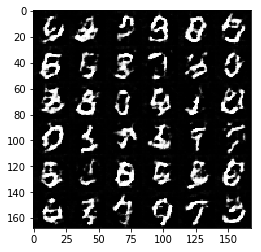

Epoch 01 |  Step  625 |  d_loss = 0.95662671 |  g_loss = 0.85015893
Epoch 01 |  Step  650 |  d_loss = 0.59975433 |  g_loss = 1.08014381
Epoch 01 |  Step  675 |  d_loss = 0.67804122 |  g_loss = 1.12309408
Epoch 01 |  Step  700 |  d_loss = 2.24415827 |  g_loss = 0.13382903


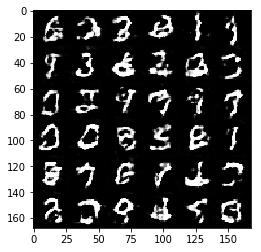

Epoch 01 |  Step  725 |  d_loss = 0.74522507 |  g_loss = 1.23438334
Epoch 01 |  Step  750 |  d_loss = 0.79193413 |  g_loss = 0.85404783
Epoch 01 |  Step  775 |  d_loss = 1.14865923 |  g_loss = 0.53305936
Epoch 01 |  Step  800 |  d_loss = 1.15706587 |  g_loss = 0.43261415


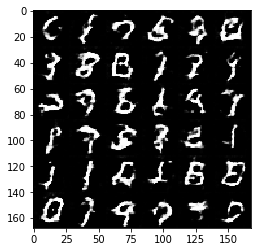

Epoch 01 |  Step  825 |  d_loss = 0.34603101 |  g_loss = 1.74750757
Epoch 01 |  Step  850 |  d_loss = 0.37976629 |  g_loss = 1.46014285
Epoch 01 |  Step  875 |  d_loss = 1.14045095 |  g_loss = 1.25269938
Epoch 01 |  Step  900 |  d_loss = 0.82876527 |  g_loss = 1.45487809


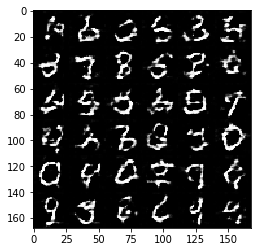

Epoch 01 |  Step  925 |  d_loss = 0.88616401 |  g_loss = 1.12396443
Epoch 01 |  Step  950 |  d_loss = 1.21177983 |  g_loss = 0.45586008
Epoch 01 |  Step  975 |  d_loss = 0.47782740 |  g_loss = 1.32988954
Epoch 01 |  Step 1000 |  d_loss = 0.57441801 |  g_loss = 1.11894178


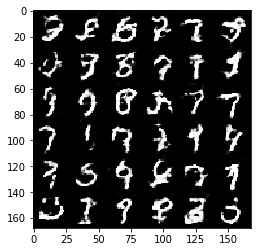

Epoch 01 |  Step 1025 |  d_loss = 1.04974747 |  g_loss = 0.54088712
Epoch 01 |  Step 1050 |  d_loss = 0.79402667 |  g_loss = 1.45807040
Epoch 01 |  Step 1075 |  d_loss = 0.55677718 |  g_loss = 1.80141497
Epoch 01 |  Step 1100 |  d_loss = 1.37947190 |  g_loss = 0.40109253


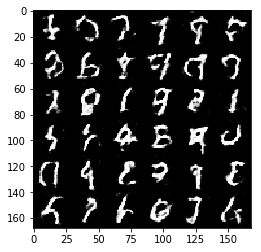

Epoch 01 |  Step 1125 |  d_loss = 0.79659450 |  g_loss = 1.07783782
Epoch 01 |  Step 1150 |  d_loss = 0.58542049 |  g_loss = 1.82412720
Epoch 01 |  Step 1175 |  d_loss = 0.71409941 |  g_loss = 0.86338401
Epoch 01 |  Step 1200 |  d_loss = 0.81765968 |  g_loss = 0.81562215


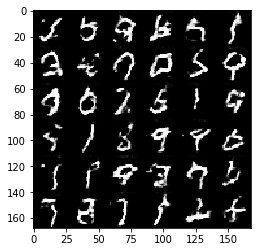

Epoch 01 |  Step 1225 |  d_loss = 0.40470374 |  g_loss = 1.44750524
Epoch 01 |  Step 1250 |  d_loss = 0.79237980 |  g_loss = 0.94611973
Epoch 01 |  Step 1275 |  d_loss = 0.55383074 |  g_loss = 1.19396341
Epoch 01 |  Step 1300 |  d_loss = 0.68354511 |  g_loss = 0.91441131


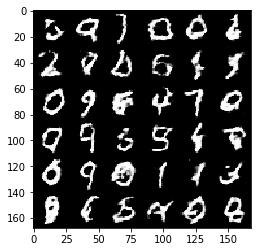

Epoch 01 |  Step 1325 |  d_loss = 0.75502193 |  g_loss = 0.86179590
Epoch 01 |  Step 1350 |  d_loss = 0.63200861 |  g_loss = 1.01121020
Epoch 01 |  Step 1375 |  d_loss = 0.57145429 |  g_loss = 2.95220137
Epoch 01 |  Step 1400 |  d_loss = 1.15040886 |  g_loss = 0.54992414


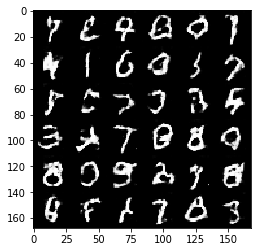

Epoch 01 |  Step 1425 |  d_loss = 0.53514421 |  g_loss = 1.15432477
Epoch 01 |  Step 1450 |  d_loss = 0.47209412 |  g_loss = 1.34284854
Epoch 01 |  Step 1475 |  d_loss = 0.41802573 |  g_loss = 1.73430574
Epoch 01 |  Step 1500 |  d_loss = 0.57464361 |  g_loss = 1.42041409


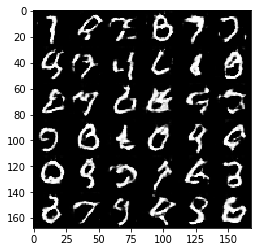

Epoch 01 |  Step 1525 |  d_loss = 0.41602266 |  g_loss = 1.82873452
Epoch 01 |  Step 1550 |  d_loss = 0.44325316 |  g_loss = 2.47765398
Epoch 01 |  Step 1575 |  d_loss = 0.27820289 |  g_loss = 1.99359679
Epoch 01 |  Step 1600 |  d_loss = 0.71134442 |  g_loss = 0.88209224


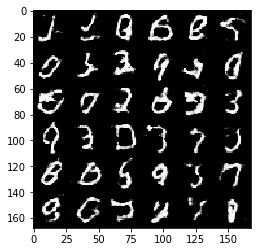

Epoch 01 |  Step 1625 |  d_loss = 0.56199139 |  g_loss = 1.05352843
Epoch 01 |  Step 1650 |  d_loss = 0.77154040 |  g_loss = 4.30128145
Epoch 01 |  Step 1675 |  d_loss = 0.48526675 |  g_loss = 1.48617077
Epoch 01 |  Step 1700 |  d_loss = 0.46310410 |  g_loss = 2.03153658


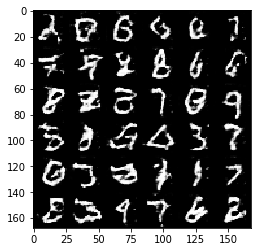

Epoch 01 |  Step 1725 |  d_loss = 0.52127165 |  g_loss = 1.44261539
Epoch 01 |  Step 1750 |  d_loss = 0.31142622 |  g_loss = 1.78844714
Epoch 01 |  Step 1775 |  d_loss = 0.72521436 |  g_loss = 0.92897063
Epoch 01 |  Step 1800 |  d_loss = 0.24575837 |  g_loss = 2.71834373


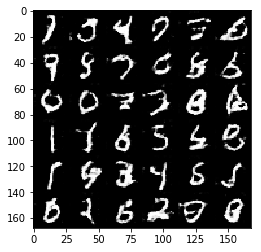

Epoch 01 |  Step 1825 |  d_loss = 0.60845435 |  g_loss = 1.13753653
Epoch 01 |  Step 1850 |  d_loss = 0.40858635 |  g_loss = 1.53448224
Epoch 01 |  Step 1875 |  d_loss = 0.89204687 |  g_loss = 0.67454582
Epoch 02 |  Step 1900 |  d_loss = 0.51717627 |  g_loss = 1.22347403


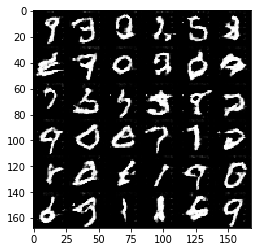

Epoch 02 |  Step 1925 |  d_loss = 0.39955935 |  g_loss = 1.70359683
Epoch 02 |  Step 1950 |  d_loss = 0.29310721 |  g_loss = 1.92138159
Epoch 02 |  Step 1975 |  d_loss = 0.71285701 |  g_loss = 0.86244947
Epoch 02 |  Step 2000 |  d_loss = 0.67409539 |  g_loss = 0.92762315


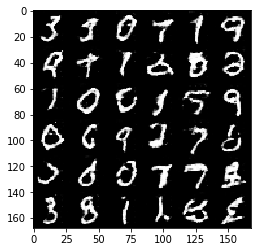

Epoch 02 |  Step 2025 |  d_loss = 0.59859872 |  g_loss = 1.11068583
Epoch 02 |  Step 2050 |  d_loss = 1.33536971 |  g_loss = 0.42006925
Epoch 02 |  Step 2075 |  d_loss = 0.45107669 |  g_loss = 1.43267965
Epoch 02 |  Step 2100 |  d_loss = 0.40759933 |  g_loss = 1.44365048


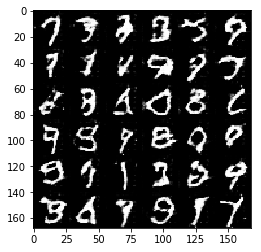

Epoch 02 |  Step 2125 |  d_loss = 0.74732220 |  g_loss = 0.99827957
Epoch 02 |  Step 2150 |  d_loss = 1.33221650 |  g_loss = 3.26676965
Epoch 02 |  Step 2175 |  d_loss = 0.67455059 |  g_loss = 2.26877785
Epoch 02 |  Step 2200 |  d_loss = 0.29581323 |  g_loss = 2.29277396


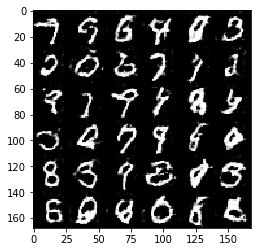

Epoch 02 |  Step 2225 |  d_loss = 1.21856928 |  g_loss = 0.53193831
Epoch 02 |  Step 2250 |  d_loss = 0.22399031 |  g_loss = 2.74790430
Epoch 02 |  Step 2275 |  d_loss = 0.28894982 |  g_loss = 1.77454543
Epoch 02 |  Step 2300 |  d_loss = 0.33053404 |  g_loss = 1.56546140


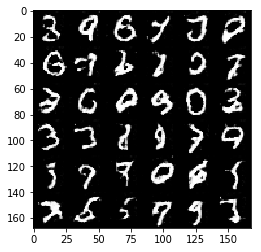

Epoch 02 |  Step 2325 |  d_loss = 0.13018662 |  g_loss = 3.26480293
Epoch 02 |  Step 2350 |  d_loss = 0.27922997 |  g_loss = 1.82167172
Epoch 02 |  Step 2375 |  d_loss = 0.60895807 |  g_loss = 2.65492535
Epoch 02 |  Step 2400 |  d_loss = 0.41320243 |  g_loss = 2.39197540


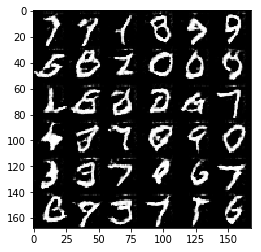

Epoch 02 |  Step 2425 |  d_loss = 0.47539216 |  g_loss = 1.49378610
Epoch 02 |  Step 2450 |  d_loss = 0.43940905 |  g_loss = 1.69113684
Epoch 02 |  Step 2475 |  d_loss = 0.61092186 |  g_loss = 1.06837583
Epoch 02 |  Step 2500 |  d_loss = 0.92140859 |  g_loss = 0.64513677


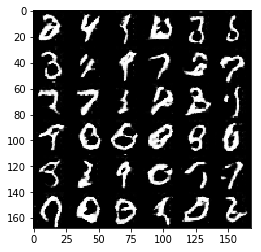

Epoch 02 |  Step 2525 |  d_loss = 0.51183516 |  g_loss = 1.20957327
Epoch 02 |  Step 2550 |  d_loss = 0.26222530 |  g_loss = 1.95707941
Epoch 02 |  Step 2575 |  d_loss = 0.35988623 |  g_loss = 1.61364651
Epoch 02 |  Step 2600 |  d_loss = 2.06135893 |  g_loss = 0.25022316


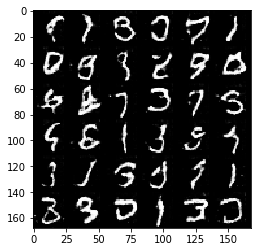

Epoch 02 |  Step 2625 |  d_loss = 0.55915123 |  g_loss = 1.21656120
Epoch 02 |  Step 2650 |  d_loss = 0.49837801 |  g_loss = 1.44854271
Epoch 02 |  Step 2675 |  d_loss = 0.93775934 |  g_loss = 0.76821101
Epoch 02 |  Step 2700 |  d_loss = 0.39045003 |  g_loss = 1.47307980


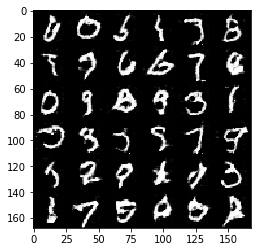

Epoch 02 |  Step 2725 |  d_loss = 0.51814771 |  g_loss = 1.30880845
Epoch 02 |  Step 2750 |  d_loss = 1.19761395 |  g_loss = 0.62630576
Epoch 02 |  Step 2775 |  d_loss = 0.33974111 |  g_loss = 1.76656461
Epoch 02 |  Step 2800 |  d_loss = 0.27943990 |  g_loss = 1.89837229


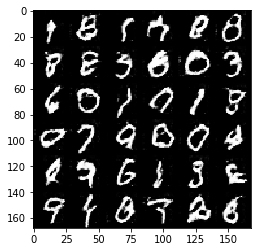

Epoch 02 |  Step 2825 |  d_loss = 0.86125368 |  g_loss = 0.67944729
Epoch 02 |  Step 2850 |  d_loss = 0.89170521 |  g_loss = 0.72731817
Epoch 02 |  Step 2875 |  d_loss = 0.29081401 |  g_loss = 1.95158362
Epoch 02 |  Step 2900 |  d_loss = 0.80619961 |  g_loss = 0.94666696


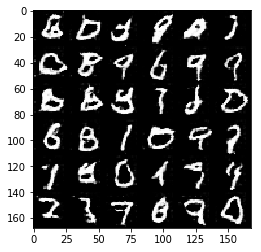

Epoch 02 |  Step 2925 |  d_loss = 0.30266485 |  g_loss = 1.61490846
Epoch 02 |  Step 2950 |  d_loss = 0.46321329 |  g_loss = 1.43670642
Epoch 02 |  Step 2975 |  d_loss = 1.27317381 |  g_loss = 0.52726817
Epoch 02 |  Step 3000 |  d_loss = 0.30442557 |  g_loss = 1.82278419


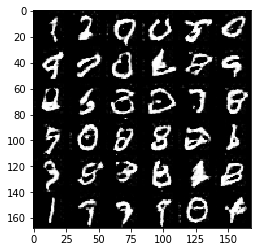

Epoch 02 |  Step 3025 |  d_loss = 0.57357663 |  g_loss = 1.12092900
Epoch 02 |  Step 3050 |  d_loss = 0.92090267 |  g_loss = 3.88662362
Epoch 02 |  Step 3075 |  d_loss = 0.36442357 |  g_loss = 1.75505757
Epoch 02 |  Step 3100 |  d_loss = 0.46917188 |  g_loss = 1.42660046


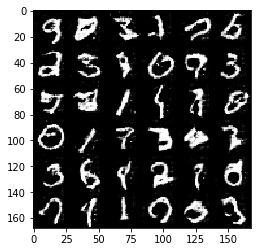

Epoch 02 |  Step 3125 |  d_loss = 1.17392886 |  g_loss = 0.67748523
Epoch 02 |  Step 3150 |  d_loss = 0.64664620 |  g_loss = 1.20764351
Epoch 02 |  Step 3175 |  d_loss = 0.45211703 |  g_loss = 1.42553902
Epoch 02 |  Step 3200 |  d_loss = 0.80138081 |  g_loss = 0.87157166


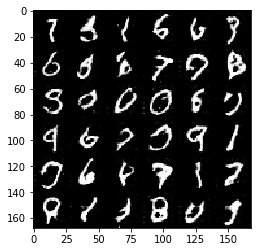

Epoch 02 |  Step 3225 |  d_loss = 0.41309372 |  g_loss = 1.62317550
Epoch 02 |  Step 3250 |  d_loss = 0.43036500 |  g_loss = 1.45372200
Epoch 02 |  Step 3275 |  d_loss = 0.64177012 |  g_loss = 1.08238852
Epoch 02 |  Step 3300 |  d_loss = 0.53426945 |  g_loss = 1.22370315


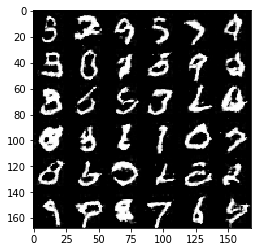

Epoch 02 |  Step 3325 |  d_loss = 0.34117687 |  g_loss = 1.70062172
Epoch 02 |  Step 3350 |  d_loss = 0.46141756 |  g_loss = 1.39724684
Epoch 02 |  Step 3375 |  d_loss = 0.26183569 |  g_loss = 2.13235235
Epoch 02 |  Step 3400 |  d_loss = 0.71628708 |  g_loss = 1.01402807


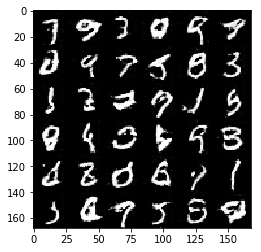

Epoch 02 |  Step 3425 |  d_loss = 0.47634757 |  g_loss = 1.50380898
Epoch 02 |  Step 3450 |  d_loss = 0.46662098 |  g_loss = 1.54084909
Epoch 02 |  Step 3475 |  d_loss = 1.40626240 |  g_loss = 3.41746044
Epoch 02 |  Step 3500 |  d_loss = 0.62529689 |  g_loss = 3.93435049


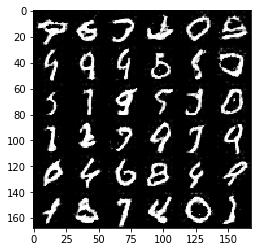

Epoch 02 |  Step 3525 |  d_loss = 0.54035825 |  g_loss = 1.36009014
Epoch 02 |  Step 3550 |  d_loss = 0.55283725 |  g_loss = 1.12928247
Epoch 02 |  Step 3575 |  d_loss = 0.36696517 |  g_loss = 1.52048898
Epoch 02 |  Step 3600 |  d_loss = 0.37832913 |  g_loss = 1.43704998


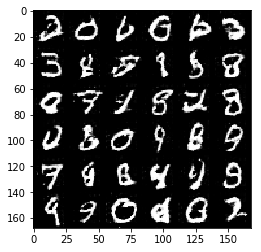

Epoch 02 |  Step 3625 |  d_loss = 0.67798692 |  g_loss = 0.87457025
Epoch 02 |  Step 3650 |  d_loss = 1.21334147 |  g_loss = 0.53555286
Epoch 02 |  Step 3675 |  d_loss = 0.57170814 |  g_loss = 1.01727390
Epoch 02 |  Step 3700 |  d_loss = 0.66497582 |  g_loss = 0.97810465


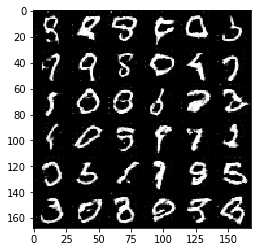

Epoch 02 |  Step 3725 |  d_loss = 1.07484710 |  g_loss = 0.66398919
Epoch 02 |  Step 3750 |  d_loss = 1.25322926 |  g_loss = 0.58631289


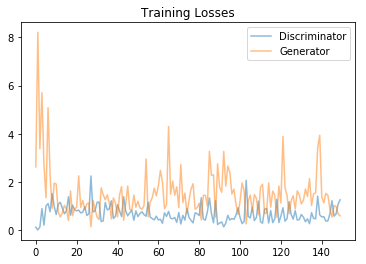

In [46]:
batch_size = 32
z_dim = 150
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 'mnist')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.